# Análise Passagens de Avião Rio - Berlim 

## Import e Pré-Processamento do Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

In [2]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)

In [3]:
df_2022 = pd.read_csv(r"C:\Users\lgrne\OneDrive\Documents\AULAS PUC BI\Projeto Final\csv_scrap\berlim_2022_v2.csv")
df_2023 = pd.read_csv(r"C:\Users\lgrne\OneDrive\Documents\AULAS PUC BI\Projeto Final\csv_scrap\berlim_2023_v2.csv")

dataframes = [df_2022,df_2023]

df_final = pd.concat(dataframes)

In [4]:
df_final = df_final.reset_index()

df_final = df_final.drop("index", axis=1)

df_final = df_final.drop("Unnamed: 0", axis=1)

In [5]:
#Limpando a coluna de preço, e convertendo os valores de string para inteiro

for i in df_final.index:
    df_final.loc[i,'Preco'] = df_final.loc[i,'Preco'].replace("R$ ","")
    df_final.loc[i,'Preco'] = df_final.loc[i,'Preco'].replace(".","")
    
df_final['Preco'] = df_final['Preco'].astype(int)

In [6]:
df_final

,Destino,Ida,Volta,Preco
0,Berlim,2022-07-01,2022-07-08,9923
1,Berlim,2022-07-03,2022-07-10,8888
2,Berlim,2022-07-06,2022-07-13,8275
3,Berlim,2022-07-09,2022-07-16,9867
4,Berlim,2022-07-12,2022-07-19,8714
...,...,...,...,...
83,Berlim,2023-05-09,2023-05-16,3682
84,Berlim,2023-05-12,2023-05-19,3970
85,Berlim,2023-05-15,2023-05-22,3970
86,Berlim,2023-05-18,2023-05-25,3682


In [7]:
#Criando um segundo dataset com as datas como index e o unico valor de preço 

df_final2 = df_final
df_final2.index = df_final['Ida']
df_final2 = df_final.drop(columns=['Destino', 'Volta','Ida'])

In [8]:
df_final2

,Preco
Ida,
2022-07-01,9923
2022-07-03,8888
2022-07-06,8275
2022-07-09,9867
2022-07-12,8714
...,...
2023-05-09,3682
2023-05-12,3970
2023-05-15,3970


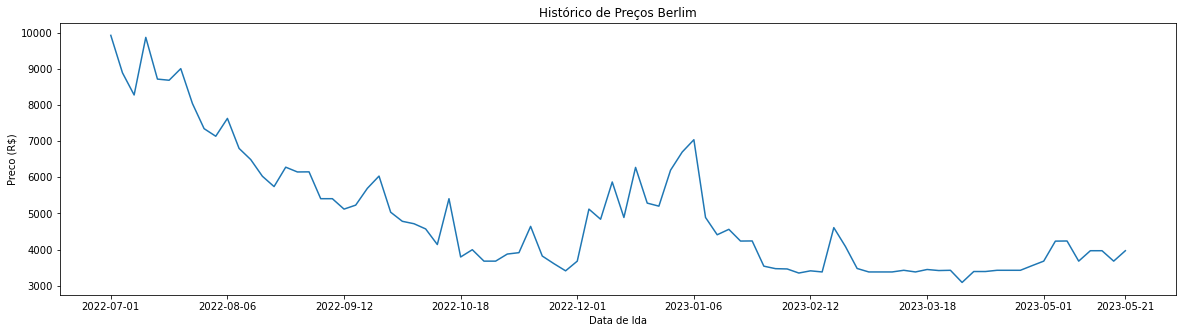

In [9]:
#Plot final do dataset

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(df_final2['Preco'])
plt.xlabel("Data de Ida")
plt.ylabel("Preco (R$)")
plt.title("Histórico de Preços Berlim")
plt.xticks([0,10,20,30,40,50,60,70,80,87]) 
plt.show()

## Separação em treino e teste

In [10]:
window = 3
dataSize = len(df_final2)
X = []
y = []
for i in range(window, dataSize):
    X.append(df_final2.iloc[i-window:i, 0])
    y.append(df_final2.iloc[i, 0])
X, y = np.array(X), np.array(y)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# imprimir
X_train[0:5]

array([[4237, 4240, 3543],
       [4608, 4085, 3479],
       [3395, 3395, 3429],
       [5694, 6033, 5034],
       [9003, 8039, 7344]])

## Funções

In [12]:
def calc_metrics (y_pred, y_test):
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mae = mean_absolute_error(y_test, y_pred)
    print('RMSE: ', rmse)
    print('MSE: ',mse)
    print('MAPE: ',mape, '%')
    print('MAE: ',mae)



In [13]:
def plotar(y_pred, y_test):
    plt.plot(y_test, label='real', marker='o')
    plt.plot(y_pred, label='previsto', marker='+')
    plt.ylabel("Preço")
    plt.title("Tempo")
    plt.legend()
    plt.show()

## Modelos

### Random Forest Regressor

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

parameter_space = \
    {
        "n_estimators": [10, 100, 300, 600],
        "criterion": ["mse", "mae"],
        "max_depth": [7, 50, 254],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 5],
        "max_features": [19, 100, X_train.shape[1]],
        "bootstrap": [True, False],
    }

model_rf = RandomizedSearchCV(RandomForestRegressor(), 
                         parameter_space, cv=3, n_jobs=-1,
                         scoring="neg_mean_absolute_error", 
                         n_iter=10)

model_rf.fit(X_train, y_train);

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [          nan           nan           nan -520.89275362           nan
           nan           nan           nan           nan -412.24538538]
  warnings.warn(


In [15]:
y_pred_rf = model_rf.predict(X_test)

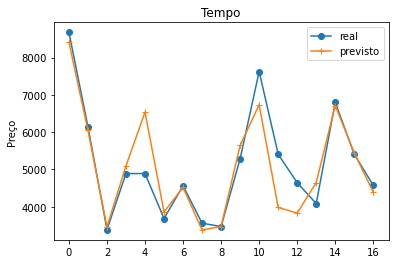

In [16]:
plotar(y_pred_rf, y_test)

In [17]:
calc_metrics(y_pred_rf, y_test)

RMSE:  637.2313409852214
MSE:  406063.7819338236
MAPE:  8.106092581409053 %
MAE:  414.92676470588236


### Decision Tree Regressor

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

parameter_space = \
    {
        "criterion": ["mse", "friedman_mse", "mae"],
        "min_samples_split": [5, 18, 29, 50],
        "min_samples_leaf": [3, 7, 15, 25],
        "max_features": [20, 50, 150, 200, X_train.shape[1]],
    }

model_dt = GridSearchCV(DecisionTreeRegressor(), parameter_space, 
                   cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)

model_dt.fit(X_train, y_train);

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
   

In [19]:
y_pred_dt = model_dt.predict(X_test)

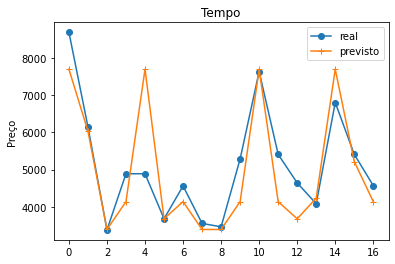

In [20]:
plotar(y_pred_dt, y_test)

In [21]:
calc_metrics(y_pred_dt, y_test)

RMSE:  923.6584627893326
MSE:  853144.9558823529
MAPE:  11.67751385065684 %
MAE:  613.3235294117648


### KNN Regressor

In [22]:
from sklearn.neighbors import KNeighborsRegressor

parameter_space = {
    "n_neighbors": [9, 10, 11,50],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": [1,2,20,50,200]
}

model_knn = GridSearchCV(KNeighborsRegressor(), parameter_space, cv=3, 
                   scoring='neg_mean_absolute_error', n_jobs=-1)

model_knn.fit(X_train, y_train);

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-533.21087688 -451.71051179 -542.28280632 -456.96842875 -545.49371182
 -459.16746768           nan           nan -533.21087688 -451.71051179
 -542.28280632 -456.96842875 -545.49371182 -459.16746768           nan
           nan -533.21087688 -451.71051179 -542.28280632 -456.96842875
 -545.49371182 -459.16746768           nan           nan -533.21087688
 -451.71051179 -542.28280632 -456.96842875 -545.49371182 -459.16746768
           nan           nan -533.21087688 -451.71051179 -542.28280632
 -456.96842875 -545.49371182 -459.16746768           nan           nan
 -533.21087688 -451.71051179 -542.28280632 -456.96842875 -545.49371182
 -459.16746768           nan           nan -533.21087688 -451.71051179
 -542.28280632 -456.96842875 -545.49371182 -459.16746768           nan
           nan -533.21087688 -451.71051179 -542.28280632 -456.96842875
 -545

In [23]:
y_pred_knn = model_knn.predict(X_test)

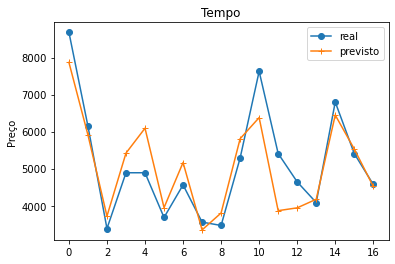

In [24]:
plotar(y_pred_knn, y_test)

In [25]:
calc_metrics(y_pred_knn, y_test)

RMSE:  686.1064872629784
MSE:  470742.1118643435
MAPE:  10.313552391033683 %
MAE:  539.2098108689621


### XGBoost

In [26]:
from xgboost import XGBRegressor

parameter_space = \
    {
        "max_depth": [4, 5, 6],
        "learning_rate": [0.005, 0.009, 0.01],
        "n_estimators": [700, 1000, 2500],
        "booster": ["gbtree",],
        "gamma": [7, 25, 100],
        "subsample": [0.3, 0.6],
        "colsample_bytree": [0.5, 0.7],
        "colsample_bylevel": [0.5, 0.7,],
        "reg_alpha": [1, 10, 33],
        "reg_lambda": [1, 3, 10],
    }

model_xgb = RandomizedSearchCV(XGBRegressor(), 
                         parameter_space, cv=3, n_jobs=-1,
                         scoring="neg_mean_absolute_error", 
                         n_iter=10)

model_xgb.fit(X_train, y_train);

In [27]:
y_pred_xgb = model_xgb.predict(X_test)

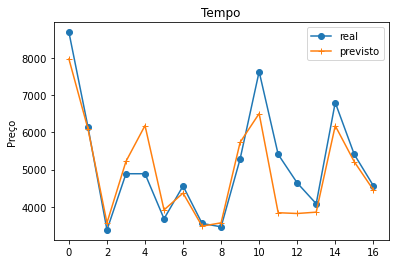

In [28]:
plotar(y_pred_xgb, y_test)

In [29]:
calc_metrics(y_pred_xgb, y_test)

RMSE:  664.7150597613166
MSE:  441846.1106734907
MAPE:  9.076437341691815 %
MAE:  488.5404411764706
